### Architecture
In this experiment swin tranformer tiny model is taken and applied on images with final head removal and single pawpularity output is added. In addition, Strong Augmentation is added to generalize the model including horizontal, vertical flipping, Random Rotation, Brightness, etc.
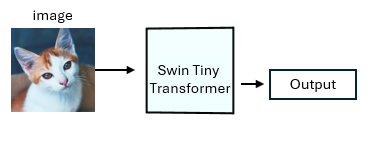

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))

In [3]:
#  imports & setup
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

from src.config import EXP_CONFIGS
from src.utils import set_seed, save_config
from src.data import build_transforms, ImageOnlyDataset
from src.models import build_vision_backbone
from src.train import train_one_epoch_image, validate_image

main_folder = ".."
data_csv = os.path.join(main_folder, "data", "train.csv")
img_folder = os.path.join(main_folder, "data", "train")
out_dir = os.path.join(main_folder, "outputs", "exp2")

df = pd.read_csv(data_csv)
cfg = EXP_CONFIGS["exp2"]

os.makedirs(out_dir, exist_ok=True)
save_config(cfg, out_dir)
set_seed(cfg["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/ghias/miniconda3/envs/rapids-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# imports and config
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import gc

gc.enable()

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

from src.config import EXP_CONFIGS
from src.utils import set_seed, save_config
from src.data import build_transforms, ImageOnlyDataset
from src.models import build_vision_backbone
from src.train import train_one_epoch_image, validate_image

main_folder = ".."
data_csv = os.path.join(main_folder, "data", "train.csv")
img_folder = os.path.join(main_folder, "data", "train")
out_dir = os.path.join(main_folder, "outputs", "exp3")

df = pd.read_csv(data_csv)
cfg = EXP_CONFIGS["exp3"]

os.makedirs(out_dir, exist_ok=True)
save_config(cfg, out_dir)
set_seed(cfg["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
#  KFold CV training loop for Exp3 (Swin-T, strong aug, BCE)

# backbone_name = cfg["backbone"]              # "swin_tiny_patch4_window7_224"
backbone_name = "swin_large_patch4_window12_384.ms_in22k"
img_size = cfg["img_size"]                  # 384 (used only in transforms)
aug_type = cfg["aug"]                       # "strong"
loss_name = cfg["loss"]                     # "bce"

n_splits = cfg["n_splits"]
epochs = cfg["epochs"]
batch_size = cfg["batch_size"]
lr = cfg["lr"]
weight_decay = cfg["weight_decay"]
patience = cfg["patience"]

kf = KFold(n_splits=n_splits, shuffle=True, random_state=cfg["seed"])
oof_pred = np.zeros(len(df))
fold_rmse = []

start_all = time.time()
for fold, (tr_idx, val_idx) in enumerate(kf.split(df)):
    print(f"\n=== {cfg['name']}: Fold {fold+1} ===")

    train_df = df.iloc[tr_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

    train_tf = build_transforms(img_size, aug_type, train=True)
    val_tf = build_transforms(img_size, aug_type, train=False)

    train_ds = ImageOnlyDataset(train_df, img_folder, train_tf)
    val_ds = ImageOnlyDataset(val_df, img_folder, val_tf)

    train_loader = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=batch_size,
                            shuffle=False, num_workers=4)

    model = build_vision_backbone(
        backbone_name, img_size, mode="regression"
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=lr, weight_decay=weight_decay
    )

    if loss_name == "bce":
        criterion = torch.nn.BCEWithLogitsLoss()
        scale_target = True
    else:
        criterion = torch.nn.MSELoss()
        scale_target = False

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs
    )

    scaler = torch.amp.GradScaler("cuda")
    best_rmse = 1e10
    best_state = None
    epochs_no_improve = 0
    train_losses, val_rmses = [], []

    epoch_logs = []
    for epoch in range(epochs):
        avg_train_loss = train_one_epoch_image(
            model, train_loader, optimizer, criterion, device,scaler, scale_target
        )
        scheduler.step()

        rmse, val_preds, val_targets = validate_image(
            model, val_loader, device, scale_target
        )
        train_losses.append(avg_train_loss)
        val_rmses.append(rmse)

        print(f"Epoch {epoch+1}/{epochs} | Fold {fold+1} "
              f"TrainLoss: {avg_train_loss:.4f} ValRMSE: {rmse:.4f}")
        
        epoch_logs.append({
            "fold": fold + 1,
            "epoch": epoch + 1,
            "train_loss": float(avg_train_loss),
            "val_rmse": float(rmse),
        })
        if rmse < best_rmse:
            best_rmse = rmse
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    pd.DataFrame(epoch_logs).to_csv(
        os.path.join(out_dir, f"epoch_logs_fold{fold+1}.csv"), index=False
    )
    # save history per fold
    hist_df = pd.DataFrame({
        "epoch": range(1, len(train_losses)+1),
        "train_loss": train_losses,
        "val_rmse": val_rmses,
    })
    hist_df.to_csv(os.path.join(out_dir, f"history_fold{fold+1}.csv"),
                   index=False)

    # OOF predictions with best weights
    model.load_state_dict(best_state)
    _, val_preds, _ = validate_image(
        model, val_loader, device, scale_target
    )
    oof_pred[val_idx] = val_preds
    fold_rmse.append(best_rmse)
    print(f"Fold {fold+1} best RMSE: {best_rmse:.4f}")

    torch.save(best_state,
               os.path.join(out_dir, f"model_fold{fold+1}.pt"))
     # Clear memory
    del model, optimizer, train_loader, val_loader, train_ds, val_ds
    torch.cuda.empty_cache()
    gc.collect()


all_sec = time.time() - start_all
print(f"\nTotal training time: {int(all_sec//60)}m {int(all_sec%60)}s")
# final OOF metrics
oof_rmse = root_mean_squared_error(df["Pawpularity"], oof_pred)
fold_rmse = np.array(fold_rmse)
print(f"\nOOF RMSE: {oof_rmse:.4f}")
print(f"Fold RMSEs: {fold_rmse.tolist()}  Mean={fold_rmse.mean():.4f}  Std={fold_rmse.std():.4f}")

oof_df = pd.DataFrame({
    "Id": df["Id"],
    "ytrue": df["Pawpularity"],
    "oof_pred": oof_pred,
})
oof_df["abs_err"] = (oof_df["ytrue"] - oof_df["oof_pred"]).abs()
oof_df.to_csv(os.path.join(out_dir, "oof_detail.csv"), index=False)
oof_df.sort_values("abs_err", ascending=False).head(50).to_csv(
    os.path.join(out_dir, "top50_errors.csv"), index=False
)

np.save(os.path.join(out_dir, "oof_pred.npy"), oof_pred)
np.save(os.path.join(out_dir, "fold_rmse.npy"), fold_rmse)
with open(os.path.join(out_dir, "metrics.txt"), "w") as f:
    f.write(f"OOF_RMSE: {oof_rmse:.4f}\n")
    f.write(f"Fold_RMSE: {fold_rmse.tolist()}\nMean: {fold_rmse.mean():.4f}\nStd: {fold_rmse.std():.4f}\n")



=== Exp3_SwinT_384_Strong: Fold 1 ===
Epoch 1/10 | Fold 1 TrainLoss: 0.6507 ValRMSE: 18.0869
Epoch 2/10 | Fold 1 TrainLoss: 0.6416 ValRMSE: 18.0408
Epoch 3/10 | Fold 1 TrainLoss: 0.6332 ValRMSE: 17.9027
Epoch 4/10 | Fold 1 TrainLoss: 0.6229 ValRMSE: 18.7323
Epoch 5/10 | Fold 1 TrainLoss: 0.6124 ValRMSE: 18.3505
Epoch 6/10 | Fold 1 TrainLoss: 0.6013 ValRMSE: 19.2263
Epoch 7/10 | Fold 1 TrainLoss: 0.5945 ValRMSE: 19.0451
Epoch 8/10 | Fold 1 TrainLoss: 0.5905 ValRMSE: 19.0680
Early stopping at epoch 8
Fold 1 best RMSE: 17.9027

=== Exp3_SwinT_384_Strong: Fold 2 ===
Epoch 1/10 | Fold 2 TrainLoss: 0.6494 ValRMSE: 18.7185
Epoch 2/10 | Fold 2 TrainLoss: 0.6382 ValRMSE: 17.8043
Epoch 3/10 | Fold 2 TrainLoss: 0.6302 ValRMSE: 18.1179
Epoch 4/10 | Fold 2 TrainLoss: 0.6195 ValRMSE: 18.9023
Epoch 5/10 | Fold 2 TrainLoss: 0.6086 ValRMSE: 18.7246
Epoch 6/10 | Fold 2 TrainLoss: 0.5993 ValRMSE: 19.2868
Epoch 7/10 | Fold 2 TrainLoss: 0.5927 ValRMSE: 19.3845
Early stopping at epoch 7
Fold 2 best RMSE: 1

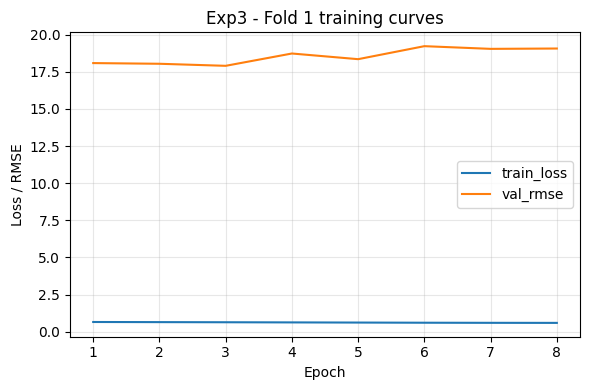

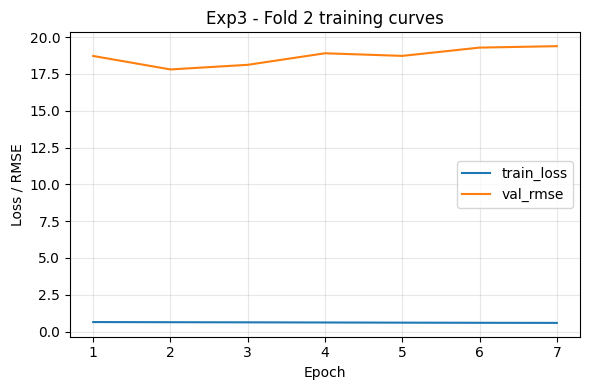

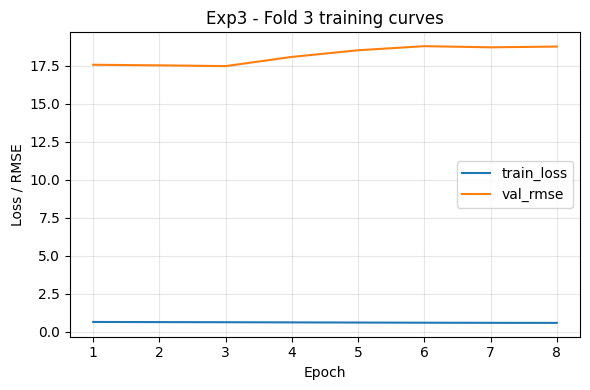

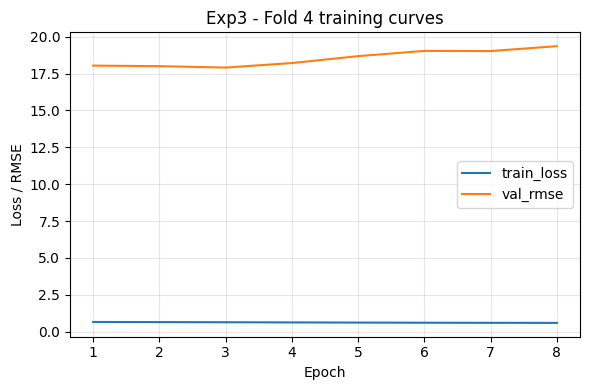

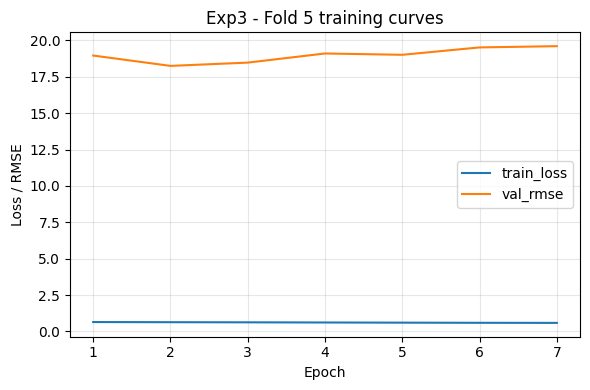

In [6]:
#  Training curves (per Sturges hist later)

for fold in [1, 2, 3, 4, 5]:
    hist_path = os.path.join(out_dir, f"history_fold{fold}.csv")
    if not os.path.exists(hist_path):
        continue
    hist = pd.read_csv(hist_path)

    plt.figure(figsize=(6,4))
    plt.plot(hist["epoch"], hist["train_loss"], label="train_loss")
    plt.plot(hist["epoch"], hist["val_rmse"], label="val_rmse")
    plt.xlabel("Epoch")
    plt.ylabel("Loss / RMSE")
    plt.title(f"Exp3 - Fold {fold} training curves")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


> The difference in both train and validation graphs lines are due to the BCE and RMSE, the model is trained on BCE Loss while for the validation data, RMSE is calculated

In [7]:
#  Inspect worst error rows

errors_path = os.path.join(out_dir, "top50_errors.csv")
err_df = pd.read_csv(errors_path)
err_df.head()


Id  ytrue   oof_pred    abs_err
0  4c1e05895368c997fdd709bbd1ac3dae      2  98.231087  96.231087
1  3d946559e2b4b210a06e9103b0dd72e9      5  95.158409  90.158409
2  2de3bf4fdcefa2f3c5e5b77fa1e3d262      5  94.336441  89.336441
3  9a76b2c5d66bc2140b53ca89a296442d      8  96.296745  88.296745
4  b2a389311b683a90c3c9763540a86bab      2  89.855614  87.855614

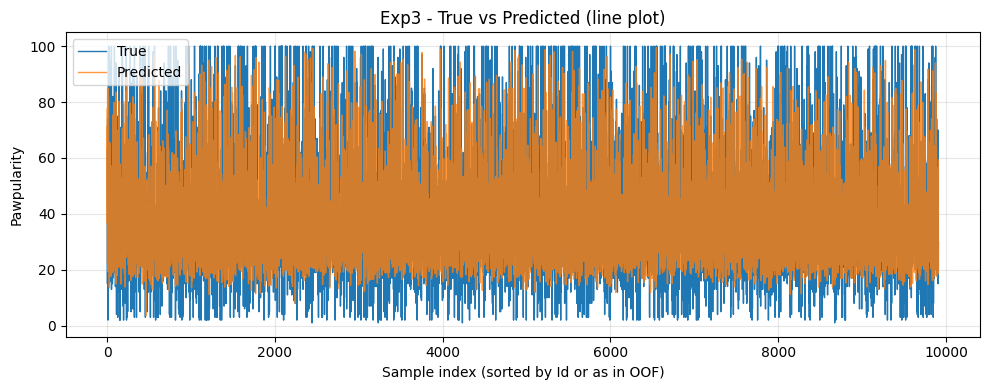

In [8]:
import os
import pandas as pd
from src.plot import (
   plot_oof_true_pred_lines,
    show_error_images_grid,
)

# Load OOF detail and top-errors
oof_df = pd.read_csv(os.path.join(out_dir, "oof_detail.csv"))
err_df = pd.read_csv(os.path.join(out_dir, "top50_errors.csv"))

# Plots
plot_oof_true_pred_lines(oof_df, title_prefix="Exp3")





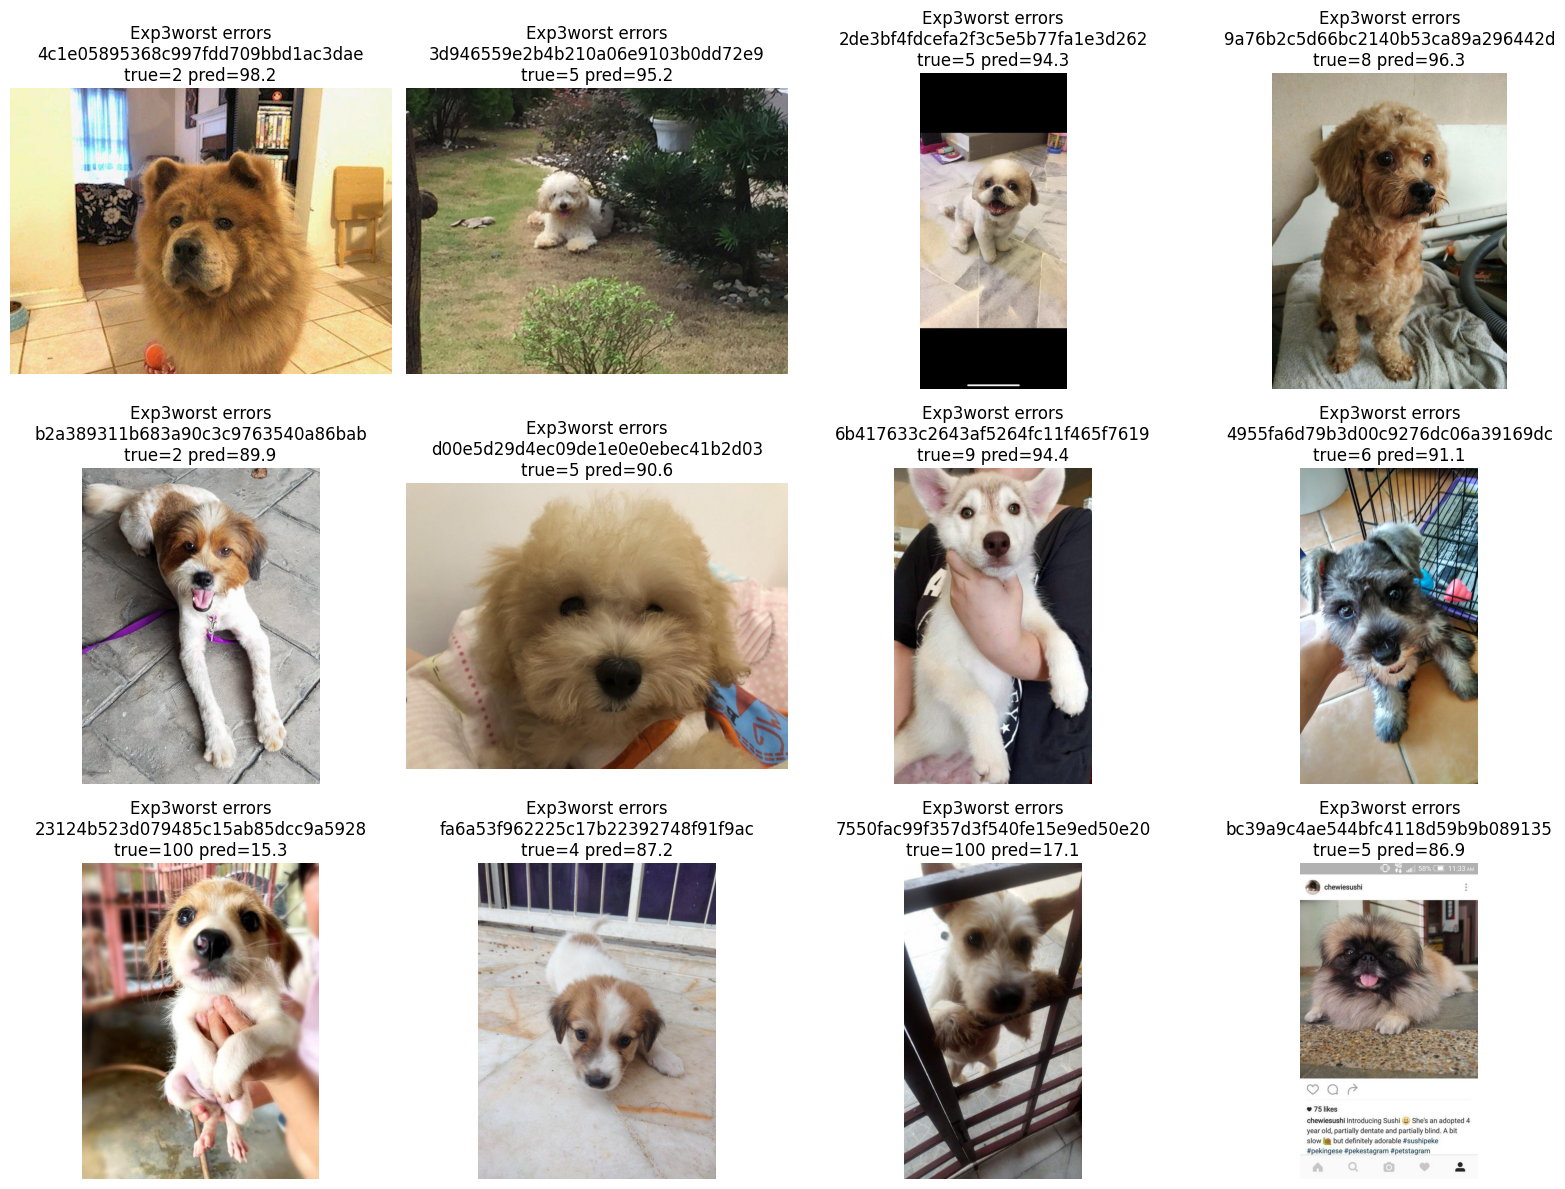

In [9]:
# Images of worst errors
img_folder = os.path.join(main_folder, "data", "train")
show_error_images_grid(err_df, img_folder, n=12, title_prefix="Exp3worst errors")

### GradCam

In [13]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms
import numpy as np
from PIL import Image
import torch

def compute_swin_gradcam(model, pil_image, img_size, target_layer, device="cuda"):
    tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ])
    img_tensor = tf(pil_image).unsqueeze(0)

    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()

    cam = GradCAM(
        model=model,
        target_layers=[target_layer],
    )
    grayscale_cam = cam(input_tensor=img_tensor.to(device))[0]  # [Hc,Wc]
    return grayscale_cam

def overlay_cam_on_pil(pil_image, cam_mask):
    rgb = np.array(pil_image).astype(np.float32) / 255.0
    h, w, _ = rgb.shape
    cam_img = Image.fromarray((cam_mask * 255).astype(np.uint8))
    cam_img = cam_img.resize((w, h), resample=Image.BILINEAR)
    cam_resized = np.array(cam_img).astype(np.float32) / 255.0
    vis = show_cam_on_image(rgb, cam_resized, use_rgb=True)
    return vis


In [14]:
target_layer = model.layers[-1].blocks[-1].norm1


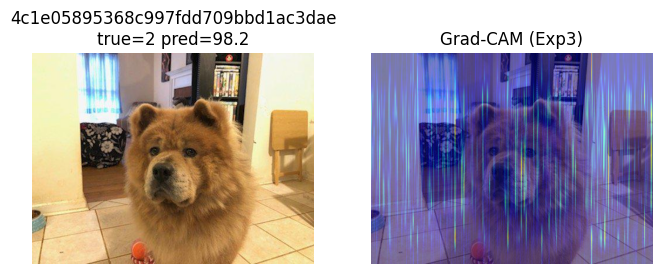

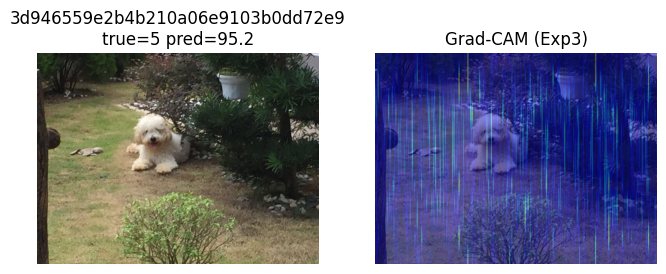

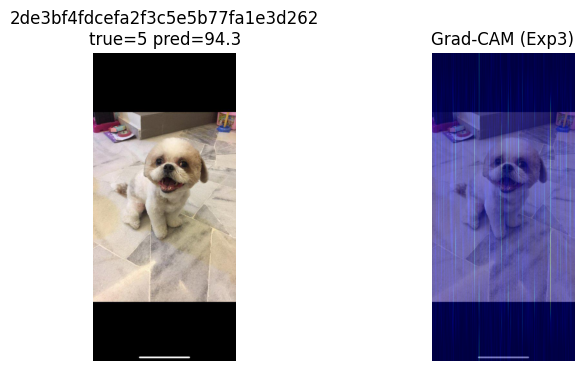

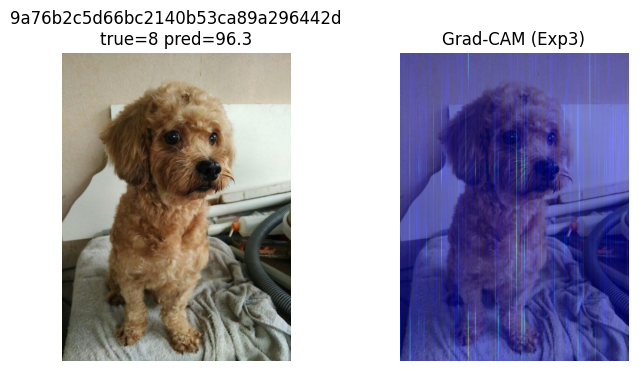

In [15]:
err_df = pd.read_csv(os.path.join(out_dir, "top50_errors.csv"))

for _, row in err_df.head(4).iterrows():
    img_id = row.Id
    pil_img = Image.open(os.path.join(img_folder, f"{img_id}.jpg")).convert("RGB")

    cam_mask = compute_swin_gradcam(
        model, pil_img, img_size, target_layer=target_layer
    )
    overlay = overlay_cam_on_pil(pil_img, cam_mask)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(pil_img); plt.axis("off")
    plt.title(f"{img_id}\ntrue={row.ytrue} pred={row.oof_pred:.1f}")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.axis("off")
    plt.title("Grad-CAM (Exp3)")
    plt.show()


### Attention Map

In [20]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt

def swin_block_cam(model, pil_image, img_size, device="cuda"):
    """
    CAM-like map from the last Swin block output (treated as [B,H,W,C]).
    """
    val_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ])
    img_tensor = val_tf(pil_image).unsqueeze(0)

    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()

    # target layer: last Swin block, but we want its output as activation
    target_layer = model.layers[-1].blocks[-1]

    # reshape [B,H,W,C] -> [B,C,H,W] for CAM
    def reshape_transform(tensor):
        # tensor is [B,H,W,C]
        if tensor.dim() == 4:
            B, H, W, C = tensor.shape
            t = tensor.permute(0, 3, 1, 2)  # [B,C,H,W]
            return t
        return tensor

    cam = GradCAM(
        model=model,
        target_layers=[target_layer],
        reshape_transform=reshape_transform,
    )
    grayscale_cam = cam(input_tensor=img_tensor.to(device))[0]  # [Hc,Wc]

    # overlay
    rgb = np.array(pil_image).astype(np.float32) / 255.0
    h, w, _ = rgb.shape
    cam_img = Image.fromarray((grayscale_cam * 255).astype(np.uint8))
    cam_img = cam_img.resize((w, h), resample=Image.BILINEAR)
    cam_resized = np.array(cam_img).astype(np.float32) / 255.0
    vis = show_cam_on_image(rgb, cam_resized, use_rgb=True)
    return vis


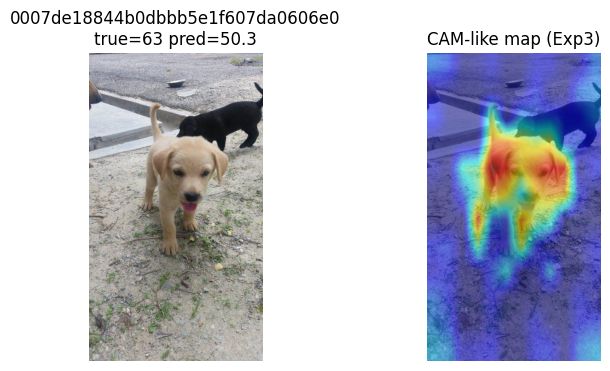

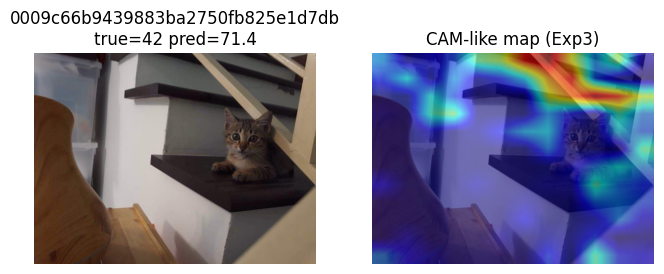

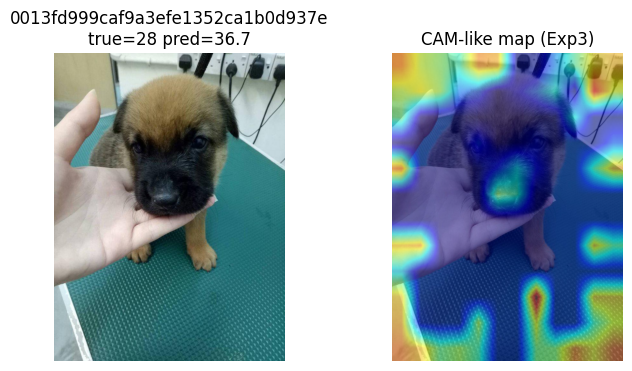

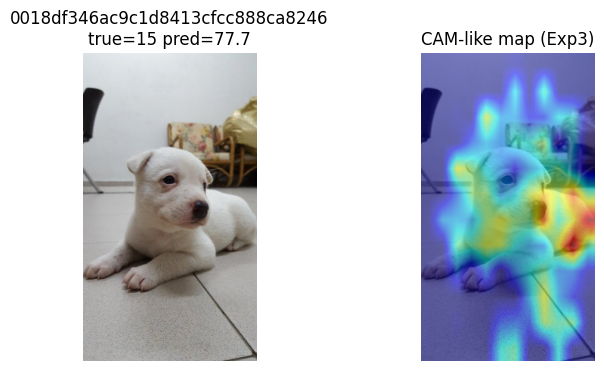

In [22]:
from src.models import build_vision_backbone

fold_to_vis = 1
model_path = os.path.join(out_dir, f"model_fold{fold_to_vis}.pt")

swin_model = build_vision_backbone(
    name=backbone_name,
    img_size=img_size,
    mode="regression",
)
swin_model.load_state_dict(torch.load(model_path, map_location="cpu"))

err_df = pd.read_csv(os.path.join(out_dir, "oof_detail.csv"))

for _, row in err_df.head(4).iterrows():
    img_id = row.Id
    pil_img = Image.open(os.path.join(img_folder, f"{img_id}.jpg")).convert("RGB")
    overlay = swin_block_cam(swin_model, pil_img, img_size, device="cuda")

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(pil_img); plt.axis("off")
    plt.title(f"{img_id}\ntrue={row.ytrue} pred={row.oof_pred:.1f}")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.axis("off")
    plt.title("CAM-like map (Exp3)")
    plt.show()
